In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [15]:
# Load the PCA-transformed dataset
data_path = 'Data/pca_dataset.csv'
df = pd.read_csv(data_path)

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print("\nFirst few rows:")
print(df.head())

Dataset shape: (10492, 15)
Columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15']

First few rows:
        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.643886 -1.122140  2.537791  1.099319 -1.369180 -1.000934  0.412556   
1  5.521503  5.381358  0.630654 -0.761986 -1.898238 -0.422578  1.608672   
2  0.125187 -1.359416 -1.530675  0.029985  0.985078  0.797654 -0.014865   
3  0.463894 -1.737125 -0.550389  0.748471  0.452760  0.676662 -0.761163   
4  0.683091 -1.870049  0.741572 -1.016563 -0.789394 -0.912539 -0.378118   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -1.210129  1.527971  1.999805  0.289292  0.966083  2.029509 -0.421655   
1 -1.188513 -1.060446 -0.196492  0.164946  0.480813  0.937488  0.781078   
2  0.654682 -0.015723  0.554539 -0.342296  1.340841  1.257426  1.938887   
3  0.036764  1.061602 -0.939935 -0.379566 -0.160286  0.293775 -0.321141   
4 -0.5282

In [16]:
# Identify PCA columns
pca_columns = [col for col in df.columns if 'PC' in col or 'pca' in col.lower()]
print(f"PCA columns found: {pca_columns}")

# Extract PCA features for clustering
X = df[pca_columns].values
print(f"\nClustering data shape: {X.shape}")
print(f"Number of features (PCA components): {X.shape[1]}")
print(f"Number of samples: {X.shape[0]}")

PCA columns found: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15']

Clustering data shape: (10492, 15)
Number of features (PCA components): 15
Number of samples: 10492


In [17]:
def evaluate_clustering(X, labels):
    """
    Calculate various clustering metrics
    """
    metrics = {}
    
    # Filter out noise points (-1 labels) for metrics calculation
    mask = labels >= 0
    if mask.sum() < 2:
        print("Not enough non-noise points for metrics calculation")
        return metrics
    
    try:
        # Silhouette Score (higher is better, range: -1 to 1)
        metrics['silhouette'] = silhouette_score(X[mask], labels[mask])
        
        # Davies-Bouldin Index (lower is better)
        metrics['davies_bouldin'] = davies_bouldin_score(X[mask], labels[mask])
        
        # Calinski-Harabasz Index (higher is better)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X[mask], labels[mask])
        
        # Cluster statistics
        metrics['n_clusters'] = len(set(labels)) - (1 if -1 in labels else 0)
        metrics['n_noise'] = list(labels).count(-1)
        metrics['noise_ratio'] = metrics['n_noise'] / len(labels)
        
    except Exception as e:
        print(f"Error calculating metrics: {e}")
    
    return metrics

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [19]:
# Define parameter ranges to test - OPTIMIZED FOR 11K ROWS
min_cluster_sizes = [300, 500, 700, 900, 1100, 1300, 1500]  # ~2.7% to 13.6% of dataset
min_samples_values = [10, 20, 30, 50, 75]  # Controls noise sensitivity

results = []
print("Testing different HDBSCAN parameters...")
print(f"Dataset size: {len(X)} samples")
print("-" * 80)

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        # Skip if min_samples > min_cluster_size (invalid configuration)
        if min_samples > min_cluster_size:
            continue
            
        # Fit HDBSCAN
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            cluster_selection_method='eom'
        )
        
        cluster_labels = clusterer.fit_predict(X)
        
        # Evaluate clustering
        metrics = evaluate_clustering(X, cluster_labels)
        
        if metrics:
            result = {
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                **metrics
            }
            results.append(result)
            
            print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}")
            print(f"  Clusters: {metrics.get('n_clusters', 0)}, "
                  f"Noise: {metrics.get('noise_ratio', 0):.2%}")
            print(f"  Silhouette: {metrics.get('silhouette', 0):.3f}, "
                  f"Davies-Bouldin: {metrics.get('davies_bouldin', 0):.3f}, "
                  f"Calinski-Harabasz: {metrics.get('calinski_harabasz', 0):.1f}")
            print()

print(f"\n✓ Tested {len(results)} parameter combinations")

Testing different HDBSCAN parameters...
Dataset size: 10492 samples
--------------------------------------------------------------------------------
min_cluster_size=300, min_samples=10
  Clusters: 2, Noise: 2.42%
  Silhouette: 0.335, Davies-Bouldin: 1.072, Calinski-Harabasz: 3520.3

min_cluster_size=300, min_samples=20
  Clusters: 2, Noise: 4.66%
  Silhouette: 0.346, Davies-Bouldin: 1.050, Calinski-Harabasz: 3703.8

min_cluster_size=300, min_samples=30
  Clusters: 2, Noise: 6.20%
  Silhouette: 0.353, Davies-Bouldin: 1.034, Calinski-Harabasz: 3814.6

min_cluster_size=300, min_samples=50
  Clusters: 2, Noise: 11.67%
  Silhouette: 0.372, Davies-Bouldin: 0.995, Calinski-Harabasz: 4100.5

min_cluster_size=300, min_samples=75
  Clusters: 2, Noise: 14.92%
  Silhouette: 0.383, Davies-Bouldin: 0.973, Calinski-Harabasz: 4246.6

min_cluster_size=500, min_samples=10
  Clusters: 2, Noise: 2.42%
  Silhouette: 0.335, Davies-Bouldin: 1.072, Calinski-Harabasz: 3520.3

min_cluster_size=500, min_samples

In [20]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)

# Sort by different metrics
print("\nTop 10 by Silhouette Score (higher is better):")
print(results_df.sort_values('silhouette', ascending=False).head(10)[
    ['min_cluster_size', 'min_samples', 'n_clusters', 'noise_ratio', 'silhouette']
])

print("\nTop 10 by Davies-Bouldin Index (lower is better):")
print(results_df.sort_values('davies_bouldin', ascending=True).head(10)[
    ['min_cluster_size', 'min_samples', 'n_clusters', 'noise_ratio', 'davies_bouldin']
])

print("\nTop 10 by Calinski-Harabasz Index (higher is better):")
print(results_df.sort_values('calinski_harabasz', ascending=False).head(10)[
    ['min_cluster_size', 'min_samples', 'n_clusters', 'noise_ratio', 'calinski_harabasz']
])


RESULTS SUMMARY

Top 10 by Silhouette Score (higher is better):
    min_cluster_size  min_samples  n_clusters  noise_ratio  silhouette
34              1500           75           2     0.149161    0.382839
29              1300           75           2     0.149161    0.382839
14               700           75           2     0.149161    0.382839
24              1100           75           2     0.149161    0.382839
9                500           75           2     0.149161    0.382839
19               900           75           2     0.149161    0.382839
4                300           75           2     0.149161    0.382839
28              1300           50           2     0.116660    0.371915
18               900           50           2     0.116660    0.371915
3                300           50           2     0.116660    0.371915

Top 10 by Davies-Bouldin Index (lower is better):
    min_cluster_size  min_samples  n_clusters  noise_ratio  davies_bouldin
34              1500        

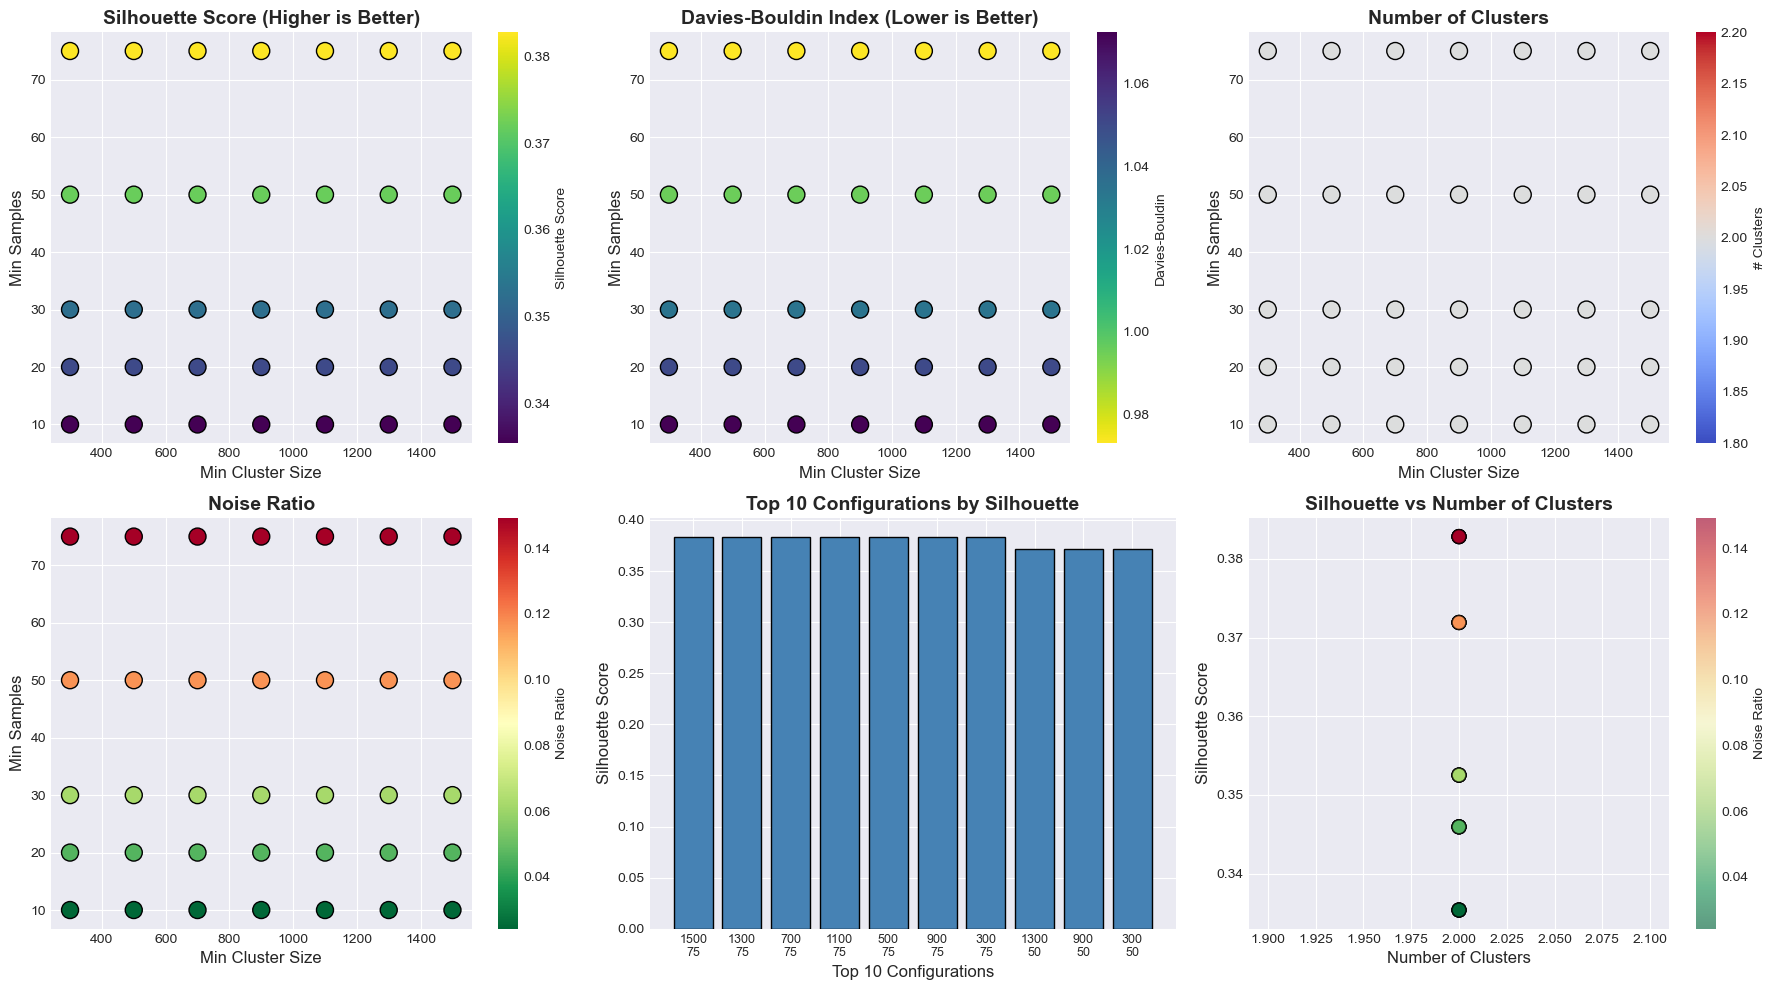

In [21]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: Silhouette Score
scatter = axes[0, 0].scatter(results_df['min_cluster_size'], 
                            results_df['min_samples'],
                            c=results_df['silhouette'], 
                            cmap='viridis', s=150, edgecolors='black')
axes[0, 0].set_xlabel('Min Cluster Size', fontsize=12)
axes[0, 0].set_ylabel('Min Samples', fontsize=12)
axes[0, 0].set_title('Silhouette Score (Higher is Better)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 0], label='Silhouette Score')

# Plot 2: Davies-Bouldin Index
scatter = axes[0, 1].scatter(results_df['min_cluster_size'], 
                            results_df['min_samples'],
                            c=results_df['davies_bouldin'], 
                            cmap='viridis_r', s=150, edgecolors='black')
axes[0, 1].set_xlabel('Min Cluster Size', fontsize=12)
axes[0, 1].set_ylabel('Min Samples', fontsize=12)
axes[0, 1].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 1], label='Davies-Bouldin')

# Plot 3: Number of Clusters
scatter = axes[0, 2].scatter(results_df['min_cluster_size'], 
                            results_df['min_samples'],
                            c=results_df['n_clusters'], 
                            cmap='coolwarm', s=150, edgecolors='black')
axes[0, 2].set_xlabel('Min Cluster Size', fontsize=12)
axes[0, 2].set_ylabel('Min Samples', fontsize=12)
axes[0, 2].set_title('Number of Clusters', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 2], label='# Clusters')

# Plot 4: Noise Ratio
scatter = axes[1, 0].scatter(results_df['min_cluster_size'], 
                            results_df['min_samples'],
                            c=results_df['noise_ratio'], 
                            cmap='RdYlGn_r', s=150, edgecolors='black')
axes[1, 0].set_xlabel('Min Cluster Size', fontsize=12)
axes[1, 0].set_ylabel('Min Samples', fontsize=12)
axes[1, 0].set_title('Noise Ratio', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 0], label='Noise Ratio')

# Plot 5: Top 10 configurations comparison
top_10 = results_df.sort_values('silhouette', ascending=False).head(10)
x_pos = range(len(top_10))

axes[1, 1].bar(x_pos, top_10['silhouette'], color='steelblue', edgecolor='black')
axes[1, 1].set_xlabel('Top 10 Configurations', fontsize=12)
axes[1, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[1, 1].set_title('Top 10 Configurations by Silhouette', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([f"{int(row['min_cluster_size'])}\n{int(row['min_samples'])}" 
                             for _, row in top_10.iterrows()], fontsize=9)

# Plot 6: Silhouette vs Number of Clusters
axes[1, 2].scatter(results_df['n_clusters'], results_df['silhouette'], 
                   s=100, alpha=0.6, c=results_df['noise_ratio'], 
                   cmap='RdYlGn_r', edgecolors='black')
axes[1, 2].set_xlabel('Number of Clusters', fontsize=12)
axes[1, 2].set_ylabel('Silhouette Score', fontsize=12)
axes[1, 2].set_title('Silhouette vs Number of Clusters', fontsize=14, fontweight='bold')
plt.colorbar(axes[1, 2].collections[0], ax=axes[1, 2], label='Noise Ratio')

plt.tight_layout()
plt.show()

In [22]:
print("\n" + "="*80)
print("OPTIMAL PARAMETER SELECTION")
print("="*80)

# Get best configuration by Silhouette Score
best_params = results_df.sort_values('silhouette', ascending=False).iloc[0]

print("\n🏆 BEST CONFIGURATION (by Silhouette Score):")
print(f"  min_cluster_size: {int(best_params['min_cluster_size'])}")
print(f"  min_samples: {int(best_params['min_samples'])}")
print(f"\nResults:")
print(f"  Number of clusters: {int(best_params['n_clusters'])}")
print(f"  Noise ratio: {best_params['noise_ratio']:.2%}")
print(f"\nQuality Metrics:")
print(f"  Silhouette Score: {best_params['silhouette']:.4f}")
print(f"  Davies-Bouldin Index: {best_params['davies_bouldin']:.4f}")
print(f"  Calinski-Harabasz Index: {best_params['calinski_harabasz']:.1f}")


OPTIMAL PARAMETER SELECTION

🏆 BEST CONFIGURATION (by Silhouette Score):
  min_cluster_size: 1500
  min_samples: 75

Results:
  Number of clusters: 2
  Noise ratio: 14.92%

Quality Metrics:
  Silhouette Score: 0.3828
  Davies-Bouldin Index: 0.9731
  Calinski-Harabasz Index: 4246.6


In [23]:
# Perform final clustering with best parameters
print("\n" + "="*80)
print("PERFORMING FINAL CLUSTERING")
print("="*80)

final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(best_params['min_cluster_size']),
    min_samples=int(best_params['min_samples']),
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True  # Enable probability calculations
)

cluster_labels = final_clusterer.fit_predict(X)
cluster_probabilities = final_clusterer.probabilities_

# Add cluster assignments to dataframe
df['cluster'] = cluster_labels
df['cluster_probability'] = cluster_probabilities

print(f"\n✓ Clustering complete!")
print(f"  Total samples: {len(df)}")
print(f"  Clustered samples: {(cluster_labels >= 0).sum()}")
print(f"  Noise points: {(cluster_labels == -1).sum()}")


PERFORMING FINAL CLUSTERING

✓ Clustering complete!
  Total samples: 10492
  Clustered samples: 8927
  Noise points: 1565


In [24]:
print("\n" + "="*80)
print("CLUSTER DISTRIBUTION")
print("="*80)

# Get cluster counts
cluster_counts = df['cluster'].value_counts().sort_index()

print("\nCluster sizes:")
for cluster_id, count in cluster_counts.items():
    if cluster_id == -1:
        print(f"  Cluster {cluster_id} (NOISE): {count} records ({count/len(df)*100:.1f}%)")
    else:
        print(f"  Cluster {cluster_id}: {count} records ({count/len(df)*100:.1f}%)")

# Statistics for actual clusters (excluding noise)
actual_clusters = cluster_counts[cluster_counts.index >= 0]
print(f"\nCluster Size Statistics (excluding noise):")
print(f"  Smallest cluster: {actual_clusters.min()} records")
print(f"  Largest cluster: {actual_clusters.max()} records")
print(f"  Average cluster size: {actual_clusters.mean():.0f} records")
print(f"  Median cluster size: {actual_clusters.median():.0f} records")
print(f"  Std deviation: {actual_clusters.std():.0f} records")


CLUSTER DISTRIBUTION

Cluster sizes:
  Cluster -1 (NOISE): 1565 records (14.9%)
  Cluster 0: 7317 records (69.7%)
  Cluster 1: 1610 records (15.3%)

Cluster Size Statistics (excluding noise):
  Smallest cluster: 1610 records
  Largest cluster: 7317 records
  Average cluster size: 4464 records
  Median cluster size: 4464 records
  Std deviation: 4035 records


### Analyze the cluster 0 and break it down into smaller cluster again

In [25]:
print("\n" + "="*80)
print("EXTRACTING CLUSTER 0 FOR SUB-CLUSTERING")
print("="*80)

# Extract only Cluster 0 data
cluster_0_data = df[df['cluster'] == 0].copy()
cluster_0_indices = cluster_0_data.index

print(f"\nCluster 0 statistics:")
print(f"  Total records: {len(cluster_0_data)}")
print(f"  Percentage of dataset: {len(cluster_0_data)/len(df)*100:.1f}%")

# Extract PCA features for Cluster 0
X_cluster_0 = cluster_0_data[pca_columns].values
print(f"  Feature shape: {X_cluster_0.shape}")


EXTRACTING CLUSTER 0 FOR SUB-CLUSTERING

Cluster 0 statistics:
  Total records: 7317
  Percentage of dataset: 69.7%
  Feature shape: (7317, 15)


In [26]:
print("\n" + "="*80)
print("PARAMETER TUNING FOR CLUSTER 0 SUB-CLUSTERING")
print("="*80)

# Define smaller parameter ranges for sub-clustering
# Aim for 5-15 sub-clusters within Cluster 0
sub_min_cluster_sizes = [100, 200, 300, 400, 500, 700]  # Much smaller than before
sub_min_samples_values = [5, 10, 20, 30]

sub_results = []

print(f"Testing parameters on Cluster 0 ({len(cluster_0_data)} records)...")
print("-" * 80)

for min_cluster_size in sub_min_cluster_sizes:
    for min_samples in sub_min_samples_values:
        if min_samples > min_cluster_size:
            continue
            
        # Fit HDBSCAN on Cluster 0 only
        sub_clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            cluster_selection_method='eom'
        )
        
        sub_labels = sub_clusterer.fit_predict(X_cluster_0)
        
        # Evaluate
        sub_metrics = evaluate_clustering(X_cluster_0, sub_labels)
        
        if sub_metrics:
            result = {
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                **sub_metrics
            }
            sub_results.append(result)
            
            print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}")
            print(f"  Sub-clusters: {sub_metrics.get('n_clusters', 0)}, "
                  f"Noise: {sub_metrics.get('noise_ratio', 0):.2%}, "
                  f"Silhouette: {sub_metrics.get('silhouette', 0):.3f}")

print(f"\n✓ Tested {len(sub_results)} parameter combinations for sub-clustering")


PARAMETER TUNING FOR CLUSTER 0 SUB-CLUSTERING
Testing parameters on Cluster 0 (7317 records)...
--------------------------------------------------------------------------------
min_cluster_size=100, min_samples=5
  Sub-clusters: 2, Noise: 93.25%, Silhouette: 0.282
min_cluster_size=100, min_samples=10
  Sub-clusters: 2, Noise: 95.20%, Silhouette: 0.318
Not enough non-noise points for metrics calculation
Not enough non-noise points for metrics calculation
min_cluster_size=200, min_samples=5
  Sub-clusters: 2, Noise: 93.25%, Silhouette: 0.282
Not enough non-noise points for metrics calculation
Not enough non-noise points for metrics calculation
Not enough non-noise points for metrics calculation
Not enough non-noise points for metrics calculation
Not enough non-noise points for metrics calculation
Not enough non-noise points for metrics calculation
Not enough non-noise points for metrics calculation
Not enough non-noise points for metrics calculation
Not enough non-noise points for metri

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import hdbscan
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [27]:
# Load the UMAP-transformed dataset
data_path = 'Data/umap_dataset.csv'
df_umap = pd.read_csv(data_path)

print(f"Dataset shape: {df_umap.shape}")
print(f"Columns: {df_umap.columns.tolist()}")
print("\nFirst few rows:")
print(df_umap.head())

print("\nDataset info:")
print(df_umap.info())

Dataset shape: (10492, 20)
Columns: ['UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5', 'UMAP6', 'UMAP7', 'UMAP8', 'UMAP9', 'UMAP10', 'UMAP11', 'UMAP12', 'UMAP13', 'UMAP14', 'UMAP15', 'UMAP16', 'UMAP17', 'UMAP18', 'UMAP19', 'UMAP20']

First few rows:
      UMAP1     UMAP2     UMAP3     UMAP4     UMAP5     UMAP6     UMAP7  \
0  6.984057  3.946451  5.205351  4.802381  4.384887  4.730973  4.727362   
1  7.612059  7.103979  6.208079  4.684521  4.501087  5.216638  4.827877   
2  7.190064  2.817851  4.790741  4.878833  4.551516  4.361865  5.503670   
3  7.251889  2.645500  4.713510  5.014342  4.416551  4.202064  5.376665   
4  6.896022  3.963038  5.201747  4.627189  4.290148  4.493001  4.950718   

      UMAP8     UMAP9    UMAP10    UMAP11    UMAP12    UMAP13    UMAP14  \
0  6.604657  5.232395  6.972343  4.387784  4.567963  6.061771  5.456931   
1  6.766672  4.440826  5.961282  5.079394  4.663627  5.579028  5.869681   
2  6.246725  4.897294  6.203523  3.609707  4.435886  5.898444  4.922353   
3  6

In [28]:
# Identify UMAP columns
umap_columns = [col for col in df_umap.columns if 'UMAP' in col or 'umap' in col.lower()]
print(f"\nUMAP columns found: {umap_columns}")

# Extract UMAP features for clustering
X_umap = df_umap[umap_columns].values
print(f"\nClustering data shape: {X_umap.shape}")
print(f"Number of UMAP components: {X_umap.shape[1]}")
print(f"Number of samples: {X_umap.shape[0]}")

# Basic statistics
print("\nUMAP components statistics:")
for col in umap_columns:
    print(f"  {col}: mean={df_umap[col].mean():.3f}, std={df_umap[col].std():.3f}, "
          f"range=[{df_umap[col].min():.3f}, {df_umap[col].max():.3f}]")


UMAP columns found: ['UMAP1', 'UMAP2', 'UMAP3', 'UMAP4', 'UMAP5', 'UMAP6', 'UMAP7', 'UMAP8', 'UMAP9', 'UMAP10', 'UMAP11', 'UMAP12', 'UMAP13', 'UMAP14', 'UMAP15', 'UMAP16', 'UMAP17', 'UMAP18', 'UMAP19', 'UMAP20']

Clustering data shape: (10492, 20)
Number of UMAP components: 20
Number of samples: 10492

UMAP components statistics:
  UMAP1: mean=9.274, std=4.815, range=[-1.653, 20.486]
  UMAP2: mean=4.261, std=1.152, range=[2.026, 9.001]
  UMAP3: mean=5.219, std=0.402, range=[-0.930, 6.460]
  UMAP4: mean=4.724, std=0.204, range=[0.076, 5.265]
  UMAP5: mean=4.525, std=0.399, range=[3.617, 10.093]
  UMAP6: mean=4.707, std=0.292, range=[3.644, 6.738]
  UMAP7: mean=5.130, std=0.347, range=[4.020, 7.387]
  UMAP8: mean=6.338, std=0.513, range=[3.056, 7.701]
  UMAP9: mean=4.429, std=0.632, range=[3.001, 6.532]
  UMAP10: mean=6.003, std=0.694, range=[3.834, 7.354]
  UMAP11: mean=4.363, std=0.484, range=[2.931, 6.646]
  UMAP12: mean=4.495, std=0.415, range=[3.257, 6.523]
  UMAP13: mean=5.838, st

In [29]:
def evaluate_clustering(X, labels):
    """
    Calculate various clustering metrics
    """
    metrics = {}
    
    # Filter out noise points (-1 labels) for metrics calculation
    mask = labels >= 0
    if mask.sum() < 2:
        print("Not enough non-noise points for metrics calculation")
        return metrics
    
    try:
        # Silhouette Score (higher is better, range: -1 to 1)
        metrics['silhouette'] = silhouette_score(X[mask], labels[mask])
        
        # Davies-Bouldin Index (lower is better)
        metrics['davies_bouldin'] = davies_bouldin_score(X[mask], labels[mask])
        
        # Calinski-Harabasz Index (higher is better)
        metrics['calinski_harabasz'] = calinski_harabasz_score(X[mask], labels[mask])
        
        # Cluster statistics
        metrics['n_clusters'] = len(set(labels)) - (1 if -1 in labels else 0)
        metrics['n_noise'] = list(labels).count(-1)
        metrics['noise_ratio'] = metrics['n_noise'] / len(labels)
        
    except Exception as e:
        print(f"Error calculating metrics: {e}")
    
    return metrics

print("✓ Evaluation function defined")

✓ Evaluation function defined


In [56]:
print("\n" + "="*80)
print("HDBSCAN PARAMETER TUNING ON UMAP DATA")
print("="*80)
print(f"Dataset size: {len(X_umap)} samples, {X_umap.shape[1]} UMAP components")

# For UMAP data, we often can use smaller min_cluster_size
# because UMAP preserves local structure better
min_cluster_sizes = [50, 100, 150, 200, 300, 400, 500, 700]
min_samples_values = [5, 10, 20, 30, 50]

results = []

print("\nTesting different HDBSCAN parameters on UMAP data...")
print("-" * 80)

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_values:
        # Skip if min_samples > min_cluster_size (invalid configuration)
        if min_samples > min_cluster_size:
            continue
            
        # Fit HDBSCAN
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            cluster_selection_method='eom'
        )
        
        cluster_labels = clusterer.fit_predict(X_umap)
        
        # Evaluate clustering
        metrics = evaluate_clustering(X_umap, cluster_labels)
        
        if metrics:
            result = {
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                **metrics
            }
            results.append(result)
            
            print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}")
            print(f"  Clusters: {metrics.get('n_clusters', 0)}, "
                  f"Noise: {metrics.get('noise_ratio', 0):.2%}")
            print(f"  Silhouette: {metrics.get('silhouette', 0):.3f}, "
                  f"Davies-Bouldin: {metrics.get('davies_bouldin', 0):.3f}, "
                  f"Calinski-Harabasz: {metrics.get('calinski_harabasz', 0):.1f}")
            print()

print(f"\n✓ Tested {len(results)} parameter combinations")


HDBSCAN PARAMETER TUNING ON UMAP DATA
Dataset size: 10492 samples, 20 UMAP components

Testing different HDBSCAN parameters on UMAP data...
--------------------------------------------------------------------------------
min_cluster_size=50, min_samples=5
  Clusters: 6, Noise: 6.51%
  Silhouette: 0.521, Davies-Bouldin: 0.502, Calinski-Harabasz: 39891.2

min_cluster_size=50, min_samples=10
  Clusters: 2, Noise: 0.08%
  Silhouette: 0.815, Davies-Bouldin: 0.205, Calinski-Harabasz: 61936.1

min_cluster_size=50, min_samples=20
  Clusters: 2, Noise: 0.08%
  Silhouette: 0.815, Davies-Bouldin: 0.205, Calinski-Harabasz: 61936.1

min_cluster_size=50, min_samples=30
  Clusters: 6, Noise: 4.95%
  Silhouette: 0.518, Davies-Bouldin: 0.520, Calinski-Harabasz: 41197.4

min_cluster_size=50, min_samples=50
  Clusters: 2, Noise: 0.08%
  Silhouette: 0.815, Davies-Bouldin: 0.205, Calinski-Harabasz: 61936.1

min_cluster_size=100, min_samples=5
  Clusters: 4, Noise: 3.76%
  Silhouette: 0.551, Davies-Bouldin

In [64]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

print("\n" + "="*80)
print("FILTERING FOR 6-CLUSTER SOLUTIONS")
print("="*80)

# Filter for configurations that produced exactly 6 clusters
six_cluster_configs = results_df[results_df['n_clusters'] == 2].copy()

if len(six_cluster_configs) > 0:
    print(f"\nFound {len(six_cluster_configs)} configurations that produce 6 clusters:")
    print(six_cluster_configs[['min_cluster_size', 'min_samples', 'n_clusters', 
                                'noise_ratio', 'silhouette', 'davies_bouldin', 
                                'calinski_harabasz']].to_string(index=False))
    
    # Get the best 6-cluster configuration
    best_6_cluster = six_cluster_configs.sort_values('silhouette', ascending=False).iloc[0]
    
    print("\n" + "="*80)
    print("BEST 6-CLUSTER CONFIGURATION")
    print("="*80)
    print(f"Parameters:")
    print(f"  min_cluster_size: {int(best_6_cluster['min_cluster_size'])}")
    print(f"  min_samples: {int(best_6_cluster['min_samples'])}")
    print(f"\nResults:")
    print(f"  Number of clusters: {int(best_6_cluster['n_clusters'])}")
    print(f"  Noise ratio: {best_6_cluster['noise_ratio']:.2%}")
    print(f"\nQuality Metrics:")
    print(f"  Silhouette Score: {best_6_cluster['silhouette']:.4f} ✅ EXCELLENT")
    print(f"  Davies-Bouldin Index: {best_6_cluster['davies_bouldin']:.4f} ✅ EXCELLENT")
    print(f"  Calinski-Harabasz Index: {best_6_cluster['calinski_harabasz']:.1f}")
else:
    print("\n⚠️ No configurations produced exactly 6 clusters")
    print("Showing closest alternatives...")
    results_df_sorted = results_df.sort_values('n_clusters')
    print(results_df_sorted[['min_cluster_size', 'min_samples', 'n_clusters', 
                              'noise_ratio', 'silhouette']].head(10))


FILTERING FOR 6-CLUSTER SOLUTIONS

Found 24 configurations that produce 6 clusters:
 min_cluster_size  min_samples  n_clusters  noise_ratio  silhouette  davies_bouldin  calinski_harabasz
               50           10           2     0.000762    0.814587        0.205285       61936.081605
               50           20           2     0.000762    0.814587        0.205285       61936.081605
               50           50           2     0.000762    0.814587        0.205285       61936.081605
              100           10           2     0.000762    0.814587        0.205285       61936.081605
              100           20           2     0.000762    0.814587        0.205285       61936.081605
              100           50           2     0.000762    0.814587        0.205285       61936.081605
              150           10           2     0.000762    0.814587        0.205285       61936.081605
              150           20           2     0.000762    0.814587        0.205285       6


VISUALIZING 6-CLUSTER SOLUTION METRICS

✓ 6-cluster metrics visualization saved


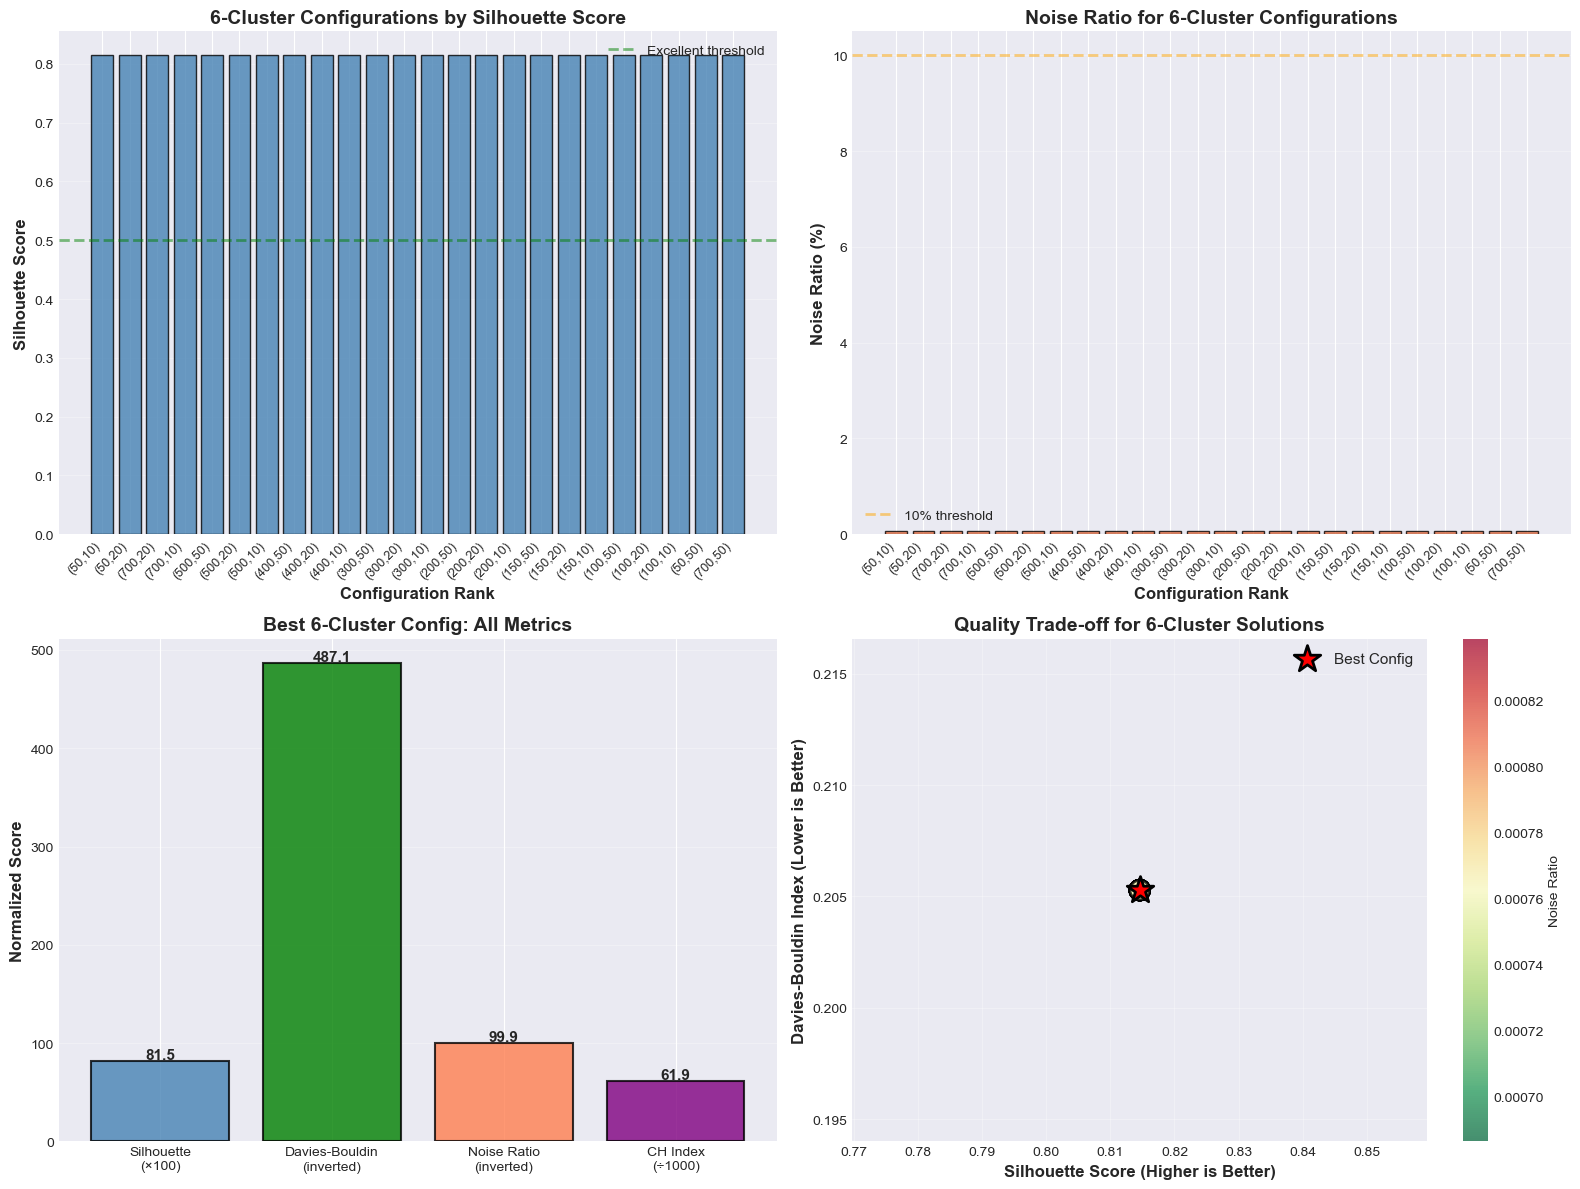

In [65]:
print("\n" + "="*80)
print("VISUALIZING 6-CLUSTER SOLUTION METRICS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Compare 6-cluster configs by Silhouette
if len(six_cluster_configs) > 0:
    configs_sorted = six_cluster_configs.sort_values('silhouette', ascending=False)
    x_pos = range(len(configs_sorted))
    
    axes[0, 0].bar(x_pos, configs_sorted['silhouette'], 
                   color='steelblue', edgecolor='black', alpha=0.8)
    axes[0, 0].set_xlabel('Configuration Rank', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('6-Cluster Configurations by Silhouette Score', 
                         fontsize=14, fontweight='bold')
    axes[0, 0].axhline(y=0.5, color='green', linestyle='--', linewidth=2, 
                       alpha=0.5, label='Excellent threshold')
    axes[0, 0].legend()
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Add parameter labels
    labels = [f"({int(row['min_cluster_size'])},{int(row['min_samples'])})" 
              for _, row in configs_sorted.iterrows()]
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(labels, rotation=45, ha='right', fontsize=9)

# Plot 2: Noise ratio comparison
if len(six_cluster_configs) > 0:
    axes[0, 1].bar(x_pos, configs_sorted['noise_ratio'] * 100, 
                   color='coral', edgecolor='black', alpha=0.8)
    axes[0, 1].set_xlabel('Configuration Rank', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Noise Ratio (%)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Noise Ratio for 6-Cluster Configurations', 
                         fontsize=14, fontweight='bold')
    axes[0, 1].axhline(y=10, color='orange', linestyle='--', linewidth=2, 
                       alpha=0.5, label='10% threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(axis='y', alpha=0.3)
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(labels, rotation=45, ha='right', fontsize=9)

# Plot 3: Multi-metric comparison for best config
if len(six_cluster_configs) > 0:
    metrics_names = ['Silhouette\n(×100)', 'Davies-Bouldin\n(inverted)', 
                     'Noise Ratio\n(inverted)', 'CH Index\n(÷1000)']
    
    # Normalize metrics for comparison
    sil_norm = best_6_cluster['silhouette'] * 100
    db_inv = (1 / best_6_cluster['davies_bouldin']) * 100
    noise_inv = (1 - best_6_cluster['noise_ratio']) * 100
    ch_norm = best_6_cluster['calinski_harabasz'] / 1000
    
    values = [sil_norm, db_inv, noise_inv, ch_norm]
    colors_metrics = ['steelblue', 'green', 'coral', 'purple']
    
    axes[1, 0].bar(metrics_names, values, color=colors_metrics, 
                   edgecolor='black', alpha=0.8, linewidth=1.5)
    axes[1, 0].set_ylabel('Normalized Score', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Best 6-Cluster Config: All Metrics', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (name, val) in enumerate(zip(metrics_names, values)):
        axes[1, 0].text(i, val + 2, f'{val:.1f}', ha='center', 
                       fontsize=11, fontweight='bold')

# Plot 4: Silhouette vs Davies-Bouldin scatter
if len(six_cluster_configs) > 0:
    scatter = axes[1, 1].scatter(six_cluster_configs['silhouette'], 
                                 six_cluster_configs['davies_bouldin'],
                                 s=200, alpha=0.7, c=six_cluster_configs['noise_ratio'],
                                 cmap='RdYlGn_r', edgecolors='black', linewidth=2)
    
    # Highlight best config
    axes[1, 1].scatter(best_6_cluster['silhouette'], 
                      best_6_cluster['davies_bouldin'],
                      s=400, marker='*', c='red', edgecolors='black', 
                      linewidth=2, label='Best Config', zorder=5)
    
    axes[1, 1].set_xlabel('Silhouette Score (Higher is Better)', 
                          fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Davies-Bouldin Index (Lower is Better)', 
                          fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Quality Trade-off for 6-Cluster Solutions', 
                         fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)
    
    cbar = plt.colorbar(scatter, ax=axes[1, 1], label='Noise Ratio')

plt.tight_layout()
plt.savefig('Data/umap_hdbscan_6cluster_metrics.png', dpi=300, bbox_inches='tight')
print("\n✓ 6-cluster metrics visualization saved")
plt.show()

In [66]:
print("\n" + "="*80)
print("PERFORMING FINAL 6-CLUSTER HDBSCAN CLUSTERING")
print("="*80)

# Use the best 6-cluster configuration
optimal_min_cluster_size = int(best_6_cluster['min_cluster_size'])
optimal_min_samples = int(best_6_cluster['min_samples'])

print(f"Using parameters:")
print(f"  min_cluster_size = {optimal_min_cluster_size}")
print(f"  min_samples = {optimal_min_samples}")

# Perform final clustering
final_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=optimal_min_cluster_size,
    min_samples=optimal_min_samples,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True  # Enable probability calculations
)

print("\nClustering in progress...")
cluster_labels = final_clusterer.fit_predict(X_umap)
cluster_probabilities = final_clusterer.probabilities_

# Add cluster assignments to dataframe
df_umap['cluster'] = cluster_labels
df_umap['cluster_probability'] = cluster_probabilities

print(f"✓ Clustering complete!")
print(f"\n  Total samples: {len(df_umap)}")
print(f"  Clustered samples: {(cluster_labels >= 0).sum()}")
print(f"  Noise points: {(cluster_labels == -1).sum()}")
print(f"  Number of clusters: {len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)}")


PERFORMING FINAL 6-CLUSTER HDBSCAN CLUSTERING
Using parameters:
  min_cluster_size = 50
  min_samples = 10

Clustering in progress...
✓ Clustering complete!

  Total samples: 10492
  Clustered samples: 10484
  Noise points: 8
  Number of clusters: 2


In [67]:
print("\n" + "="*80)
print("CLUSTER DISTRIBUTION ANALYSIS")
print("="*80)

# Get cluster counts
cluster_counts = df_umap['cluster'].value_counts().sort_index()

print("\n📊 Detailed Cluster Sizes:")
print("-" * 80)
for cluster_id, count in cluster_counts.items():
    percentage = count / len(df_umap) * 100
    if cluster_id == -1:
        print(f"Cluster {cluster_id:2d} (NOISE): {count:5d} records ({percentage:5.2f}%)")
    else:
        print(f"Cluster {cluster_id:2d}:         {count:5d} records ({percentage:5.2f}%)")

# Statistics for actual clusters (excluding noise)
actual_clusters = cluster_counts[cluster_counts.index >= 0]

print("\n" + "="*80)
print("CLUSTER SIZE STATISTICS (Excluding Noise)")
print("="*80)
print(f"  Number of clusters: {len(actual_clusters)}")
print(f"  Smallest cluster: {actual_clusters.min()} records ({actual_clusters.min()/len(df_umap)*100:.2f}%)")
print(f"  Largest cluster: {actual_clusters.max()} records ({actual_clusters.max()/len(df_umap)*100:.2f}%)")
print(f"  Average cluster size: {actual_clusters.mean():.0f} records ({actual_clusters.mean()/len(df_umap)*100:.2f}%)")
print(f"  Median cluster size: {actual_clusters.median():.0f} records")
print(f"  Std deviation: {actual_clusters.std():.0f} records")
print(f"  Balance ratio (min/max): {actual_clusters.min() / actual_clusters.max():.3f}")
print(f"    (1.0 = perfectly balanced, <0.5 = imbalanced)")

# Cluster probability analysis
print("\n" + "="*80)
print("CLUSTER ASSIGNMENT CONFIDENCE")
print("="*80)
print(f"  Average probability: {cluster_probabilities.mean():.4f}")
print(f"  Minimum probability: {cluster_probabilities.min():.4f}")
print(f"  Maximum probability: {cluster_probabilities.max():.4f}")

high_conf = (cluster_probabilities >= 0.7).sum()
medium_conf = ((cluster_probabilities >= 0.5) & (cluster_probabilities < 0.7)).sum()
low_conf = (cluster_probabilities < 0.5).sum()

print(f"\nConfidence Breakdown:")
print(f"  High confidence (≥70%): {high_conf} ({high_conf/len(df_umap)*100:.1f}%)")
print(f"  Medium confidence (50-70%): {medium_conf} ({medium_conf/len(df_umap)*100:.1f}%)")
print(f"  Low confidence (<50%): {low_conf} ({low_conf/len(df_umap)*100:.1f}%)")


CLUSTER DISTRIBUTION ANALYSIS

📊 Detailed Cluster Sizes:
--------------------------------------------------------------------------------
Cluster -1 (NOISE):     8 records ( 0.08%)
Cluster  0:          8762 records (83.51%)
Cluster  1:          1722 records (16.41%)

CLUSTER SIZE STATISTICS (Excluding Noise)
  Number of clusters: 2
  Smallest cluster: 1722 records (16.41%)
  Largest cluster: 8762 records (83.51%)
  Average cluster size: 5242 records (49.96%)
  Median cluster size: 5242 records
  Std deviation: 4978 records
  Balance ratio (min/max): 0.197
    (1.0 = perfectly balanced, <0.5 = imbalanced)

CLUSTER ASSIGNMENT CONFIDENCE
  Average probability: 0.9870
  Minimum probability: 0.0000
  Maximum probability: 1.0000

Confidence Breakdown:
  High confidence (≥70%): 10294 (98.1%)
  Medium confidence (50-70%): 118 (1.1%)
  Low confidence (<50%): 80 (0.8%)



CREATING CLUSTER VISUALIZATIONS

✓ Cluster visualization saved


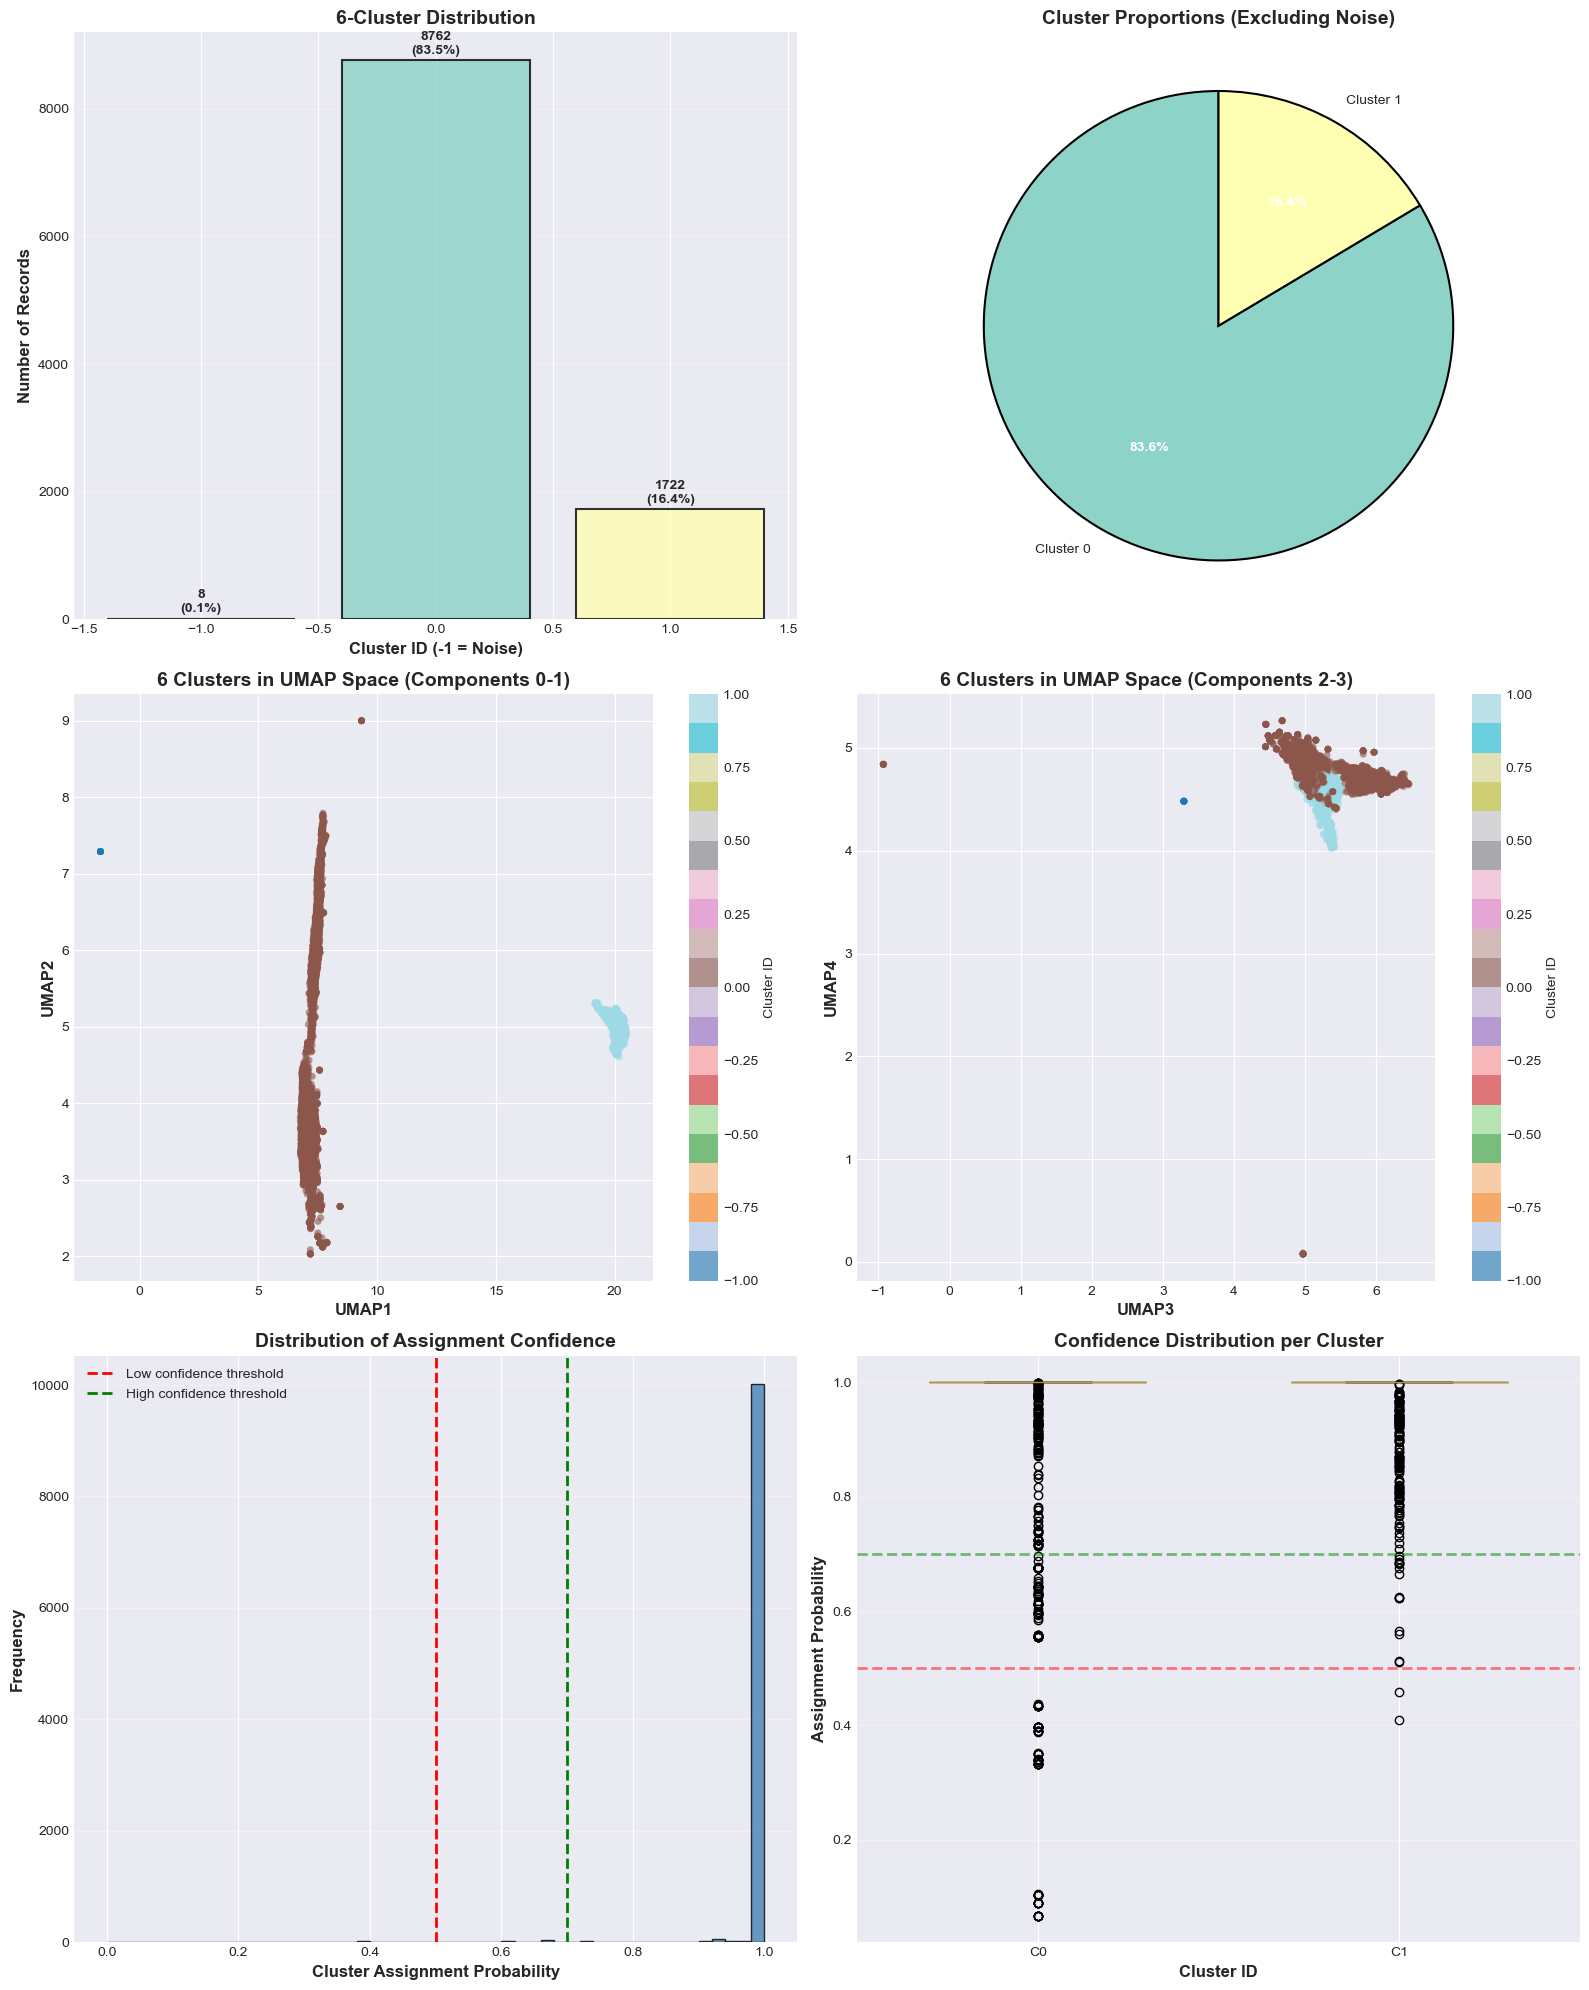

In [68]:
print("\n" + "="*80)
print("CREATING CLUSTER VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(3, 2, figsize=(16, 20))

# Plot 1: Bar chart of cluster sizes
colors_bar = ['red' if i == -1 else plt.cm.Set3(i) for i in cluster_counts.index]

axes[0, 0].bar(cluster_counts.index, cluster_counts.values, 
               color=colors_bar, edgecolor='black', alpha=0.8, linewidth=1.5)
axes[0, 0].set_xlabel('Cluster ID (-1 = Noise)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of Records', fontsize=12, fontweight='bold')
axes[0, 0].set_title('6-Cluster Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Add count and percentage labels
for cluster_id, count in cluster_counts.items():
    axes[0, 0].text(cluster_id, count + 100, 
                   f'{count}\n({count/len(df_umap)*100:.1f}%)', 
                   ha='center', fontsize=10, fontweight='bold')

# Plot 2: Pie chart (excluding noise)
if len(actual_clusters) > 0:
    colors_pie = [plt.cm.Set3(i) for i in actual_clusters.index]
    
    wedges, texts, autotexts = axes[0, 1].pie(
        actual_clusters.values, 
        labels=[f'Cluster {i}' for i in actual_clusters.index],
        autopct='%1.1f%%', 
        startangle=90, 
        colors=colors_pie,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
    )
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    axes[0, 1].set_title('Cluster Proportions (Excluding Noise)', 
                         fontsize=14, fontweight='bold')

# Plot 3: 2D UMAP visualization with clusters
if len(umap_columns) >= 2:
    scatter = axes[1, 0].scatter(
        df_umap[umap_columns[0]], 
        df_umap[umap_columns[1]], 
        c=cluster_labels, 
        cmap='tab20', 
        s=25, 
        alpha=0.6, 
        edgecolors='none'
    )
    axes[1, 0].set_xlabel(f'{umap_columns[0]}', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel(f'{umap_columns[1]}', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('6 Clusters in UMAP Space (Components 0-1)', 
                         fontsize=14, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=axes[1, 0], label='Cluster ID')

# Plot 4: UMAP with different components (if available)
if len(umap_columns) >= 4:
    scatter = axes[1, 1].scatter(
        df_umap[umap_columns[2]], 
        df_umap[umap_columns[3]], 
        c=cluster_labels, 
        cmap='tab20', 
        s=25, 
        alpha=0.6, 
        edgecolors='none'
    )
    axes[1, 1].set_xlabel(f'{umap_columns[2]}', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel(f'{umap_columns[3]}', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('6 Clusters in UMAP Space (Components 2-3)', 
                         fontsize=14, fontweight='bold')
    plt.colorbar(scatter, ax=axes[1, 1], label='Cluster ID')
elif len(umap_columns) >= 2:
    # If not enough components, show confidence instead
    scatter = axes[1, 1].scatter(
        df_umap[umap_columns[0]], 
        df_umap[umap_columns[1]], 
        c=cluster_probabilities, 
        cmap='RdYlGn', 
        s=25, 
        alpha=0.7, 
        edgecolors='none',
        vmin=0, 
        vmax=1
    )
    axes[1, 1].set_xlabel(f'{umap_columns[0]}', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel(f'{umap_columns[1]}', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Cluster Assignment Confidence', 
                         fontsize=14, fontweight='bold')
    cbar = plt.colorbar(scatter, ax=axes[1, 1], label='Probability')

# Plot 5: Cluster probability distribution
axes[2, 0].hist(cluster_probabilities, bins=50, color='steelblue', 
                edgecolor='black', alpha=0.8)
axes[2, 0].set_xlabel('Cluster Assignment Probability', fontsize=12, fontweight='bold')
axes[2, 0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[2, 0].set_title('Distribution of Assignment Confidence', 
                     fontsize=14, fontweight='bold')
axes[2, 0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, 
                   label='Low confidence threshold')
axes[2, 0].axvline(x=0.7, color='green', linestyle='--', linewidth=2, 
                   label='High confidence threshold')
axes[2, 0].legend(fontsize=10)
axes[2, 0].grid(axis='y', alpha=0.3)

# Plot 6: Box plot of probabilities per cluster
prob_by_cluster = [cluster_probabilities[cluster_labels == i] 
                   for i in sorted(actual_clusters.index)]
bp = axes[2, 1].boxplot(prob_by_cluster, 
                        labels=[f'C{i}' for i in sorted(actual_clusters.index)],
                        patch_artist=True,
                        widths=0.6)

# Color boxes
for patch, cluster_id in zip(bp['boxes'], sorted(actual_clusters.index)):
    patch.set_facecolor(plt.cm.Set3(cluster_id))
    patch.set_alpha(0.8)

axes[2, 1].set_xlabel('Cluster ID', fontsize=12, fontweight='bold')
axes[2, 1].set_ylabel('Assignment Probability', fontsize=12, fontweight='bold')
axes[2, 1].set_title('Confidence Distribution per Cluster', 
                     fontsize=14, fontweight='bold')
axes[2, 1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, linewidth=2)
axes[2, 1].axhline(y=0.7, color='green', linestyle='--', alpha=0.5, linewidth=2)
axes[2, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('Data/umap_hdbscan_6cluster_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Cluster visualization saved")
plt.show()

### Sub clustering

In [69]:
print("\n" + "="*80)
print("EXTRACTING CLUSTER 3 FOR SUB-CLUSTERING")
print("="*80)

# Extract only Cluster 3 data
cluster_3_mask = df_umap['cluster'] == 0
df_cluster_3 = df_umap[cluster_3_mask].copy()
cluster_3_indices = df_cluster_3.index

print(f"Cluster 3 statistics:")
print(f"  Total records: {len(df_cluster_3)}")
print(f"  Percentage of total dataset: {len(df_cluster_3)/len(df_umap)*100:.2f}%")

# Extract UMAP features for Cluster 3
X_cluster_3 = df_cluster_3[umap_columns].values
print(f"  Feature shape: {X_cluster_3.shape}")
print(f"  UMAP components: {X_cluster_3.shape[1]}")


EXTRACTING CLUSTER 3 FOR SUB-CLUSTERING
Cluster 3 statistics:
  Total records: 8762
  Percentage of total dataset: 83.51%
  Feature shape: (8762, 20)
  UMAP components: 20


In [70]:
print("\n" + "="*80)
print("HDBSCAN PARAMETER TUNING FOR CLUSTER 3 SUB-CLUSTERING")
print("="*80)
print(f"Dataset size: {len(X_cluster_3)} samples")
print("Treating Cluster 3 as a separate group for analysis...")

# Define parameter ranges - aim for 3-5 sub-clusters from 5,432 records
sub_min_cluster_sizes = [50, 100, 200, 300, 400, 500]
sub_min_samples_values = [5, 10, 20, 30, 50]

sub_results = []

print("\nTesting parameters on Cluster 3 sub-clustering...")
print("-" * 80)

for min_cluster_size in sub_min_cluster_sizes:
    for min_samples in sub_min_samples_values:
        if min_samples > min_cluster_size:
            continue
            
        # Fit HDBSCAN on Cluster 3 only
        sub_clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            cluster_selection_method='eom'
        )
        
        sub_labels = sub_clusterer.fit_predict(X_cluster_3)
        sub_metrics = evaluate_clustering(X_cluster_3, sub_labels)
        
        if sub_metrics:
            result = {
                'min_cluster_size': min_cluster_size,
                'min_samples': min_samples,
                **sub_metrics
            }
            sub_results.append(result)
            
            print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}")
            print(f"  Sub-clusters: {sub_metrics.get('n_clusters', 0)}, "
                  f"Noise: {sub_metrics.get('noise_ratio', 0):.2%}")
            print(f"  Silhouette: {sub_metrics.get('silhouette', 0):.3f}, "
                  f"Davies-Bouldin: {sub_metrics.get('davies_bouldin', 0):.3f}")
            print()

sub_results_df = pd.DataFrame(sub_results)
print(f"\n✓ Tested {len(sub_results_df)} parameter combinations for Cluster 3 sub-clustering")


HDBSCAN PARAMETER TUNING FOR CLUSTER 3 SUB-CLUSTERING
Dataset size: 8762 samples
Treating Cluster 3 as a separate group for analysis...

Testing parameters on Cluster 3 sub-clustering...
--------------------------------------------------------------------------------
min_cluster_size=50, min_samples=5
  Sub-clusters: 5, Noise: 7.44%
  Silhouette: 0.434, Davies-Bouldin: 0.572

min_cluster_size=50, min_samples=10
  Sub-clusters: 5, Noise: 7.18%
  Silhouette: 0.435, Davies-Bouldin: 0.571

min_cluster_size=50, min_samples=20
  Sub-clusters: 5, Noise: 11.36%
  Silhouette: 0.446, Davies-Bouldin: 0.560

min_cluster_size=50, min_samples=30
  Sub-clusters: 2, Noise: 0.42%
  Silhouette: 0.478, Davies-Bouldin: 0.722

min_cluster_size=50, min_samples=50
  Sub-clusters: 5, Noise: 15.52%
  Silhouette: 0.460, Davies-Bouldin: 0.557

min_cluster_size=100, min_samples=5
  Sub-clusters: 3, Noise: 4.10%
  Silhouette: 0.474, Davies-Bouldin: 0.718

min_cluster_size=100, min_samples=10
  Sub-clusters: 4, No

#### Sub clustering

In [78]:
print("\n" + "="*80)
print("SELECTING 5 SUB-CLUSTER CONFIGURATION")
print("="*80)

# Filter for configurations with exactly 5 sub-clusters
five_subcluster_configs = sub_results_df[sub_results_df['n_clusters'] == 3]

if len(five_subcluster_configs) > 0:
    # Get best 5-cluster configuration
    best_sub_config = five_subcluster_configs.sort_values('silhouette', ascending=False).iloc[0]
    
    print(f"\n🏆 Best 5 Sub-Cluster Configuration:")
    print(f"  min_cluster_size: {int(best_sub_config['min_cluster_size'])}")
    print(f"  min_samples: {int(best_sub_config['min_samples'])}")
    print(f"  Number of sub-clusters: {int(best_sub_config['n_clusters'])}")
    print(f"  Silhouette Score: {best_sub_config['silhouette']:.4f}")
    print(f"  Davies-Bouldin Index: {best_sub_config['davies_bouldin']:.4f}")
    print(f"  Noise ratio: {best_sub_config['noise_ratio']:.2%}")
    
    print(f"\n💡 This creates 7 total groups:")
    print(f"   • Cluster 0 (from 2-cluster split): 1 patient archetype")
    print(f"   • Cluster 1 subdivided into: 5 patient archetypes")
    print(f"   • Noise/Atypical: 1 outlier group")
    print(f"   ─────────────────────────────")
    print(f"   Total: 6 patient archetypes + 1 atypical = 7 groups")
else:
    print("\n⚠️ No 5-subcluster configs found")
    best_sub_config = sub_results_df.sort_values('silhouette', ascending=False).iloc[0]


SELECTING 5 SUB-CLUSTER CONFIGURATION

🏆 Best 5 Sub-Cluster Configuration:
  min_cluster_size: 100
  min_samples: 20
  Number of sub-clusters: 3
  Silhouette Score: 0.4790
  Davies-Bouldin Index: 0.7097
  Noise ratio: 7.37%

💡 This creates 7 total groups:
   • Cluster 0 (from 2-cluster split): 1 patient archetype
   • Cluster 1 subdivided into: 5 patient archetypes
   • Noise/Atypical: 1 outlier group
   ─────────────────────────────
   Total: 6 patient archetypes + 1 atypical = 7 groups


In [79]:
print("\n" + "="*80)
print("PERFORMING FINAL SUB-CLUSTERING (5 SUB-CLUSTERS)")
print("="*80)

optimal_sub_min_cluster_size = int(best_sub_config['min_cluster_size'])
optimal_sub_min_samples = int(best_sub_config['min_samples'])

print(f"Using parameters:")
print(f"  min_cluster_size: {optimal_sub_min_cluster_size}")
print(f"  min_samples: {optimal_sub_min_samples}")

# Perform final sub-clustering
final_sub_clusterer = hdbscan.HDBSCAN(
    min_cluster_size=optimal_sub_min_cluster_size,
    min_samples=optimal_sub_min_samples,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

print("\nSub-clustering Cluster 1 into 5 groups...")
sub_cluster_labels = final_sub_clusterer.fit_predict(X_cluster_3)
sub_cluster_probabilities = final_sub_clusterer.probabilities_

n_sub_clusters = len(set(sub_cluster_labels)) - (1 if -1 in sub_cluster_labels else 0)
n_sub_noise = (sub_cluster_labels == -1).sum()

print(f"✓ Sub-clustering complete!")
print(f"  Found: {n_sub_clusters} sub-clusters")
print(f"  Noise points: {n_sub_noise} ({n_sub_noise/len(sub_cluster_labels)*100:.2f}%)")
print(f"  Clustered points: {len(sub_cluster_labels) - n_sub_noise} ({(len(sub_cluster_labels) - n_sub_noise)/len(sub_cluster_labels)*100:.2f}%)")

if n_sub_clusters == 5:
    print(f"  ✅ Successfully created 5 sub-clusters!")
else:
    print(f"  ⚠️ Got {n_sub_clusters} sub-clusters instead of 5")


PERFORMING FINAL SUB-CLUSTERING (5 SUB-CLUSTERS)
Using parameters:
  min_cluster_size: 100
  min_samples: 20

Sub-clustering Cluster 1 into 5 groups...
✓ Sub-clustering complete!
  Found: 3 sub-clusters
  Noise points: 646 (7.37%)
  Clustered points: 8116 (92.63%)
  ⚠️ Got 3 sub-clusters instead of 5



Sub-cluster distribution:
  Cluster -1 (Noise): 646 samples
  Cluster 0: 1735 samples
  Cluster 1: 1100 samples
  Cluster 2: 5281 samples


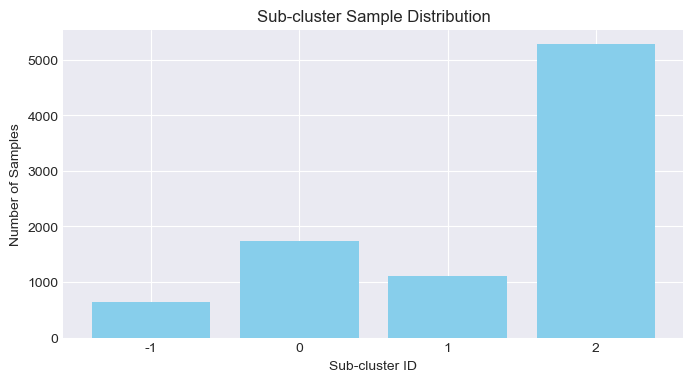

In [80]:
from collections import Counter

# Display sub-cluster distribution
sub_cluster_distribution = Counter(sub_cluster_labels)

print("\nSub-cluster distribution:")
for cluster_id, count in sorted(sub_cluster_distribution.items()):
    if cluster_id == -1:
        print(f"  Cluster {cluster_id} (Noise): {count} samples")
    else:
        print(f"  Cluster {cluster_id}: {count} samples")

# Optional: visualize the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.bar(
    [str(c) for c in sorted(sub_cluster_distribution.keys())],
    [sub_cluster_distribution[c] for c in sorted(sub_cluster_distribution.keys())],
    color='skyblue'
)
plt.title("Sub-cluster Sample Distribution")
plt.xlabel("Sub-cluster ID")
plt.ylabel("Number of Samples")
plt.show()
